# Binning

### Getting started

Binning variables is a procedure that finds multiple applications in Data Science. Some examples are provided below:

- **Univariate tests**: Specific univariate tests (like the PSI test, commonly used in the Credit Risk Domain) requires the data to be binneed, as they measure discretized shifts in the distribution of the variables.<br>
- **Plotting calibration curves** Specific models requires the predicted probabilities to be calibrated (see [probability calibration](https://scikit-learn.org/stable/modules/calibration.html)). In order to visualize the probability distribution, the predicted probabilities.


### API
`probatus` implements different binning strategies, in a simple API.<br>
The binning strategies are encoded in `Bucketer` classes.

Every `Bucketer` implements the following methods:
- `fit(X,y=None)`: calculates the optimal bins based on the type of `bucketer`.
- `compute(X)`: returns the counts of the variable in bins defined by the fitted `bucketer`.

Each bucketer has the following attributes:
- `counts`: array of counts from the fitted distribution
- `boundaries`: returns the boundaries that define the bin edges



In [1]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

# Implementations

`probatus` implements different bucketers, described below.

# Distribution related Bucketers
- `SimpleBucketer`: splits the data in equally-sized bins of the feature X
- `QuantileBucketer`: splits the data in bins of equal frequency X




In [2]:
from probatus.binning import SimpleBucketer, QuantileBucketer

### Setup: create some data

Let's create some data on which we want to apply the `SimpleBucketer` and `QuantileBucketer` strategies.<br> We choose a logistic function because it clearly supports the explanation on how binning strategies work.

In [3]:
def log_function(x):
    return 1/(1+np.exp(-x))

x = [log_function(x) for x in np.arange(-10,10,0.01)]


mySimpleBucketer = SimpleBucketer(bin_count=4).fit(x)
myQuantileBucketer = QuantileBucketer(bin_count=4).fit(x)

simple_counts = mySimpleBucketer.compute(x)
quantile_counts = myQuantileBucketer.compute(x)
print(f'Counts simple Bucketer   {simple_counts}')
print(f'Counts quantile Bucketer {quantile_counts}')

Counts simple Bucketer   [891 109 110 890]
Counts quantile Bucketer [500 500 500 500]


And the boundaries

In [4]:
print(f'Boundaries simple Bucketer   {np.round(mySimpleBucketer.boundaries_,2)}')
print(f'Boundaries quantile Bucketer {np.round(myQuantileBucketer.boundaries_,2)}')

Boundaries simple Bucketer   [0.   0.25 0.5  0.75 1.  ]
Boundaries quantile Bucketer [0.   0.01 0.5  0.99 1.  ]


Visualizing the distributions...

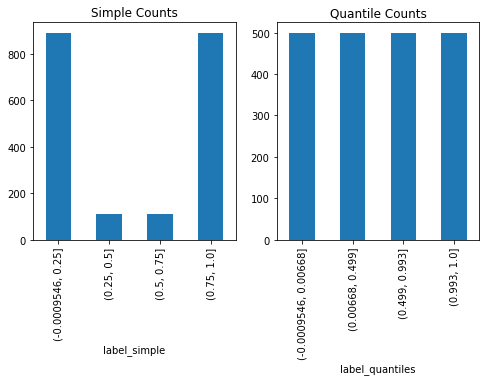

In [5]:
df = pd.DataFrame({'x':x})
df['label_simple'] = pd.cut(x, bins=mySimpleBucketer.boundaries_, include_lowest=True)
df['label_quantiles'] = pd.cut(x, bins=myQuantileBucketer.boundaries_, include_lowest=True)

fig, ax = plt.subplots(1,2, figsize = (8,4))
df.groupby('label_simple')['x'].count().plot(kind='bar', ax = ax[0]);
df.groupby('label_quantiles')['x'].count().plot(kind='bar', ax = ax[1]);
ax[0].set_title('Simple Counts');
ax[1].set_title('Quantile Counts');

# Clustering bucketers

The `AgglomerativeBucketer` class applies the Scikit-Learn `AgglomerativeClustering` algorithm to the data and uses the clusters to determine the bins.
We use different data to show the value of this algoritm; we create the following distribution:

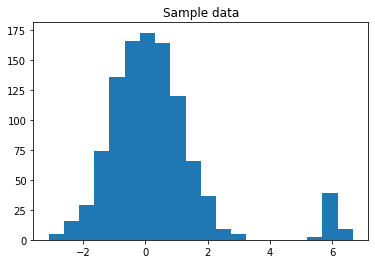

In [6]:
from probatus.binning import AgglomerativeBucketer

x_agglomerative = np.append(np.random.normal(0,1,size=1000), np.random.normal(6,0.2,size=50))
plt.hist(x_agglomerative, bins=20);
plt.title('Sample data');

When we apply the `AgglomerativeBucketer` algorithm with 2 bins, we see that the algorithm nicely creates a split in between the two centers

In [7]:
myAgglomerativeBucketer = AgglomerativeBucketer(bin_count=2)
myAgglomerativeBucketer.fit(x_agglomerative)
print('counts', myAgglomerativeBucketer.counts_)
print('boundaries', myAgglomerativeBucketer.boundaries_)

counts [1000   50]
boundaries [-3.1176238815145143, 4.176041560131348, 6.671740193897687]


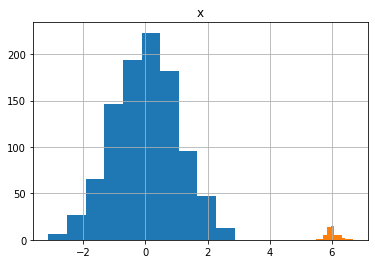

In [8]:
df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=myAgglomerativeBucketer.boundaries_, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

Note that the `SimpleBucketer` strategy would just have created a split in the middle of the maximum and the minimum (at about 1.75). The `QuantileBucketer` strategy had created two bins with equal amount of elements in it, resulting in a split at around 0.

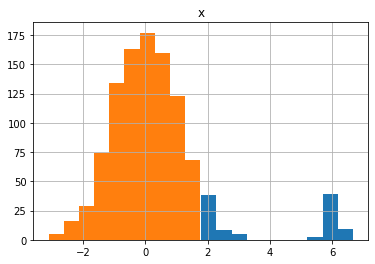

In [9]:
counts_agglomerative_simple, boundaries_agglomerative_simple = SimpleBucketer.simple_bins(x_agglomerative, 2)

df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=boundaries_agglomerative_simple, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

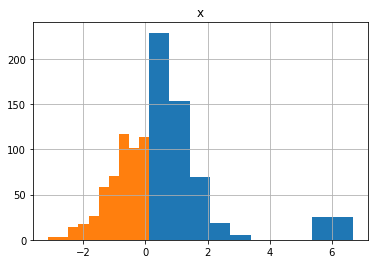

In [10]:
counts_agglomerative_quantile, boundaries_agglomerative_quantile = QuantileBucketer.quantile_bins(x_agglomerative, 2)

df = pd.DataFrame({'x':x_agglomerative})
df['label'] = pd.cut(x_agglomerative, bins=boundaries_agglomerative_quantile, include_lowest=True)

fig, ax = plt.subplots()
for label in df.label.unique():
    df[df.label==label].hist(ax=ax)

# Target-driven bucketers
#### Binning with Decision Trees

Binning with decision trees leverages the information of a binary feature or the binary target in order to create buckets that have a significantly different proportion of the binary feature/target. <br>

It works by fitting a tree on 1 feature only. <br>
It leverages the properties of the split finder algorithm in the decision tree. The splits are done to maximize the gini/entropy. <br> 
The leaves approximate the optimal bins.

The example below shows a distribution defined by a step function

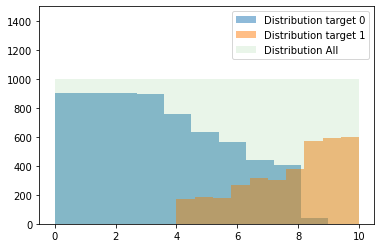

In [11]:
def make_step_function(x):
    if x<4:
        return 0.001
    elif x<6:
        return 0.3
    elif x<8:
        return 0.5
    elif x<9:
        return 0.95
    else: return 0.9999
    

x = np.arange(0,10,0.001)
probs = [make_step_function(x_) for x_ in x]

y = np.array([1 if np.random.rand()<prob else 0 for prob in probs])

fig, ax = plt.subplots()

ax.hist(x[y==0], alpha=0.5, label = 'Distribution target 0')
ax.hist(x[y==1], alpha=0.5, label = 'Distribution target 1')
ax.hist(x, alpha=0.1, label = 'Distribution All')
ax.set_ylim(0,1500)

ax.legend()
plt.show()

The overall distribution is made of two sub distributions, defined by the target y:
- the light blue histogram indicates the distribution of class 0 (`y=0`), 
- the light orange histogram indicates the distribution of class 1 (`y=1`). <br>


counts by TreeBucketer: [4002 2001 1999  986 1012]
counts by QuantileBucketer: [625 625 625 625 625 625 625 625 625 625 625 625 625 625 625 625]


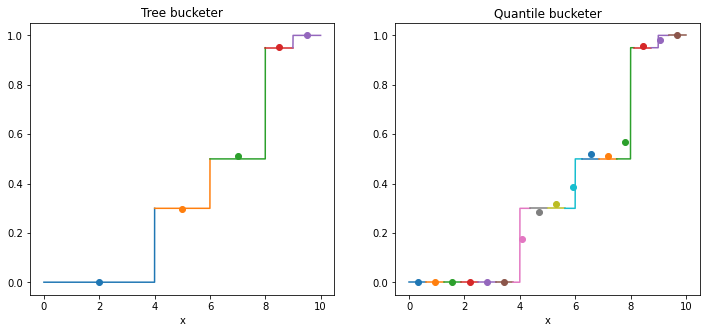

In [12]:
from probatus.binning import TreeBucketer

# Try a tree bucketer
tb = TreeBucketer(
    inf_edges=True, 
    max_leaf_nodes = 16,
    criterion = 'entropy',
   min_samples_leaf =0.05 , #Minimum fraction of entries in the bins
   min_impurity_decrease=0.001
).fit(x,y)

counts_tree, boundaries_tree = tb.counts_, tb.boundaries_

df_tree = pd.DataFrame({
    'x':x, 
    'y':y,
    'probs':probs
})

df_tree['label'] = pd.cut(x, bins=boundaries_tree, include_lowest=True)

# Try a quantile bucketer
myQuantileBucketer = QuantileBucketer(bin_count=16)
myQuantileBucketer.fit(x)
q_boundaries =  myQuantileBucketer.boundaries_
q_counts =  myQuantileBucketer.counts_

df_q = pd.DataFrame({
    'x':x, 
    'y':y,
    'probs':probs
})
df_q['label'] = pd.cut(x, bins=q_boundaries, include_lowest=True)


fig, ax = plt.subplots(1,2, figsize = (12,5))

for label in df_tree.label.unique():
    df_tree[df_tree.label==label].plot(ax=ax[0], x = 'x', y='probs', legend=False)
    ax[0].scatter( df_tree[df_tree.label==label]['x'].mean(), df_tree[df_tree.label==label]['y'].mean())
    ax[0].set_title("Tree bucketer")
    
for label in df_q.label.unique():
    df_q[df_q.label==label].plot(ax=ax[1], x = 'x', y='probs', legend=False)
    ax[1].scatter(df_q[df_q.label==label]['x'].mean(), df_q[df_q.label==label]['y'].mean())
    ax[1].set_title("Quantile bucketer")
    
print(f"counts by TreeBucketer: {counts_tree}")
print(f"counts by QuantileBucketer: {q_counts}")

Comparing the `TreeBucketer` and the `QuantileBucketer` (the dots compare the average distribution of class 1 in the bin): <br>
Each buckets obtained by the `TreeBucketer` follow the probability distribution (ie the entries in the bucket have the same probability of being class 1). <br>
On the contrary, the `QuantileBucketer` splits the values below 4 in 6 buckets, which all have the same probability of being class 1.<br>
Note also that the tree is grown with the maximum depth of 4, which potentially let's it grow up to 16 buckets ($2^4$).<br>

The learned tree is visualized below, whreere the splitting according to the step function is visualized clearly.



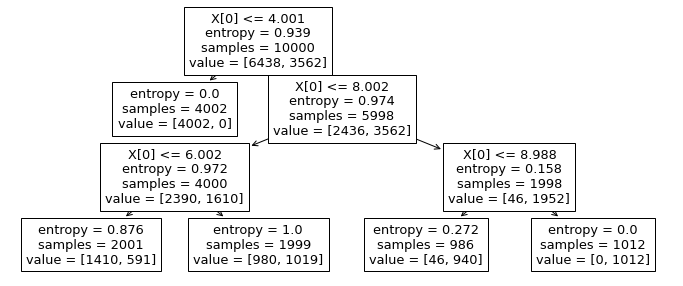

In [13]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize = (12,5))
tre_out = plot_tree(tb.tree, ax = ax)

# Extra: handy applications of probatus Bucketers


### Distribution Visualizations
Visualization of distributions can lead to misinterpretation, take the example below:<br>

- Generate `X1` as a normal distribution of 1000 enties
- `X2` equals `X1` + one outlier

`X1` and `X2` are effectively the same distribution, but visualizing them in 6 bins givers a different interpetation.



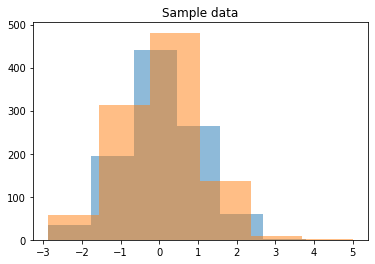

In [19]:
X1 = np.random.normal(0,1,size=1000)
X2 = np.hstack([X1,[5]])
plt.hist(X1, bins=6, alpha = 0.5);
plt.hist(X2, bins=6, alpha = 0.5);
plt.title('Sample data');


By Fitting the simple bucketer to X1, and applying it to X1 and X2, we conclude that they are effectively the same distribution.

Counts X1 [ 35 194 442 265  61   3]
Counts X2 [ 35 194 442 265  61   3]


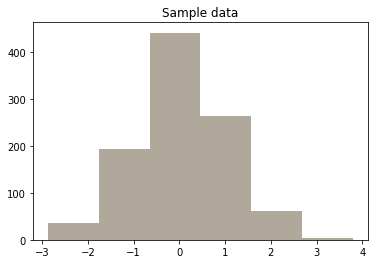

In [20]:
bucketer = SimpleBucketer(6).fit(X1)
counts_1 = bucketer.compute(X1)
counts_2 = bucketer.compute(X2)

print(f'Counts X1 {counts_1}')
print(f'Counts X2 {counts_2}')

plt.hist(X1, bins=bucketer.boundaries_, alpha = 0.5);
plt.hist(X2, bins=bucketer.boundaries_, alpha = 0.3);
plt.title('Sample data');

# Grouping applications into buckets

A common practice for checking the model performace, is the evaluation of its Rank Ordering.<br>
This is usually done by scoring a sample, and then creating buckets of applications with a similar prediction.

This becomes very tricky in the scenario of highly imbalanced data sets, as the one created below


In [21]:
from sklearn.datasets import make_classification

X,y =  make_classification(10000, flip_y =0.5)

### Add some imbalance (cca 5%)
X_0 = X[y==0]
X_1 = X[y==1]
y_1 = y[y==1]
y_1[:int(0.9*y_1.shape[0])]=0

y = np.hstack([y[y==0],y_1])

np.unique(y, return_counts=True)

(array([0, 1]), array([9500,  500]))

This dataset has only 5% of targets  `y=1`

In [17]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X,y)
proba = lr.predict_proba(X)[:,1]

prob_buckets = pd.DataFrame({
    "y":y,
    "proba":proba
}).sort_values(by='proba')

# Create simple buckets
prob_buckets["bin_s"]=pd.cut(prob_buckets['proba'], bins=SimpleBucketer(bin_count=6).fit(proba).boundaries_, include_lowest=True)

# Create tree buckets
prob_buckets["bin_t"]=pd.cut(prob_buckets['proba'], bins=TreeBucketer(inf_edges=True, 
    max_leaf_nodes = 6,
   min_samples_leaf =0.05
).fit(proba,y).boundaries_, include_lowest=True)

print("\nSimple bucketing")
# Groupby
simple_buckets = prob_buckets.groupby('bin_s',as_index=False).agg({
    "y":["mean","sum"],
    "proba":"mean",
    
})
display(simple_buckets)

print("\nTree bucketing")

tree_buckets = prob_buckets.groupby('bin_t', as_index=False).agg({
    "y":["mean","sum"],
    "proba":"mean",
    
})

display(tree_buckets)


Simple bucketing


bin_s         y          proba
                         mean  sum      mean
0  (0.0289, 0.0397]  0.038585   24  0.037410
1  (0.0397, 0.0495]  0.043413  202  0.045268
2  (0.0495, 0.0593]  0.056730  220  0.053464
3   (0.0593, 0.069]  0.055412   43  0.062642
4   (0.069, 0.0788]  0.061538    4  0.071638
5  (0.0788, 0.0886]  0.333333    2  0.083598


Tree bucketing


bin_t         y          proba
                         mean  sum      mean
0    (-inf, 0.0471]  0.041075  159  0.042900
1   (0.0471, 0.052]  0.046802  131  0.049533
2   (0.052, 0.0541]  0.065411   66  0.053049
3  (0.0541, 0.0556]  0.047187   26  0.054800
4  (0.0556, 0.0584]  0.075738   59  0.056913
5     (0.0584, inf]  0.054490   54  0.062800

Note how the buckets after the decision tree bucketers give a more representative picture towards higher values of predicted probabilities.